# Implementing the TIEGCM into ODL
### Part 2: new interpolation method

In [32]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [33]:
#######################################################
# PART 2: writing a new interpolation method
#######################################################

tiegcm = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/tiegcm_dietrich_truth/tiegcm_trueLow.nc.175001') # use UT01 on 23/06/08 as the example
tiegcm

<xarray.Dataset>
Dimensions:  (lon: 72, lat: 36, lev: 29, time: 1, timedim: 3, ens: 1, ilev: 29)
Coordinates:
  * lon      (lon) float64 -180.0 -175.0 -170.0 -165.0 ... 165.0 170.0 175.0
  * lat      (lat) float64 -87.5 -82.5 -77.5 -72.5 -67.5 ... 72.5 77.5 82.5 87.5
  * lev      (lev) float64 -6.75 -6.25 -5.75 -5.25 -4.75 ... 5.75 6.25 6.75 7.25
    ilev     (lev) float64 ...
Dimensions without coordinates: time, timedim, ens
Data variables: (12/18)
    mtime    (time, timedim) timedelta64[ns] ...
    ZG       (ens, ilev, lat, lon) float64 ...
    ZG_lev   (lev, lat, lon) float64 ...
    DEN      (ens, lev, lat, lon) float64 ...
    DEN340   (lat, lon) float64 ...
    DEN500   (lat, lon) float64 ...
    ...       ...
    O2       (ens, lev, lat, lon) float64 ...
    HE       (ens, lev, lat, lon) float64 ...
    HE500    (lat, lon) float64 ...
    NE       (ens, ilev, lat, lon) float64 ...
    Kp       (ens, time) float64 ...
    f107d    (ens, time) float64 ...

In [34]:
interpolate = RegularGridInterpolator((tiegcm.lat,tiegcm.lon),tiegcm.ZG_lev.values[0,:,:], method='linear')

In [35]:
interpolate((-87.5,-180))

array(9781662.92225744)

In [36]:
tiegcm.ZG_lev.values[0,0,0]

9781662.922257442

In [37]:
interp2 = RegularGridInterpolator((tiegcm.lev, tiegcm.lat, tiegcm.lon), tiegcm.DEN.values[0,:,:,:], method='linear')

In [38]:
interp3 = RegularGridInterpolator((tiegcm.ens, tiegcm.lev, tiegcm.lat, tiegcm.lon), tiegcm.DEN.values[:,:,:,:], method='linear')

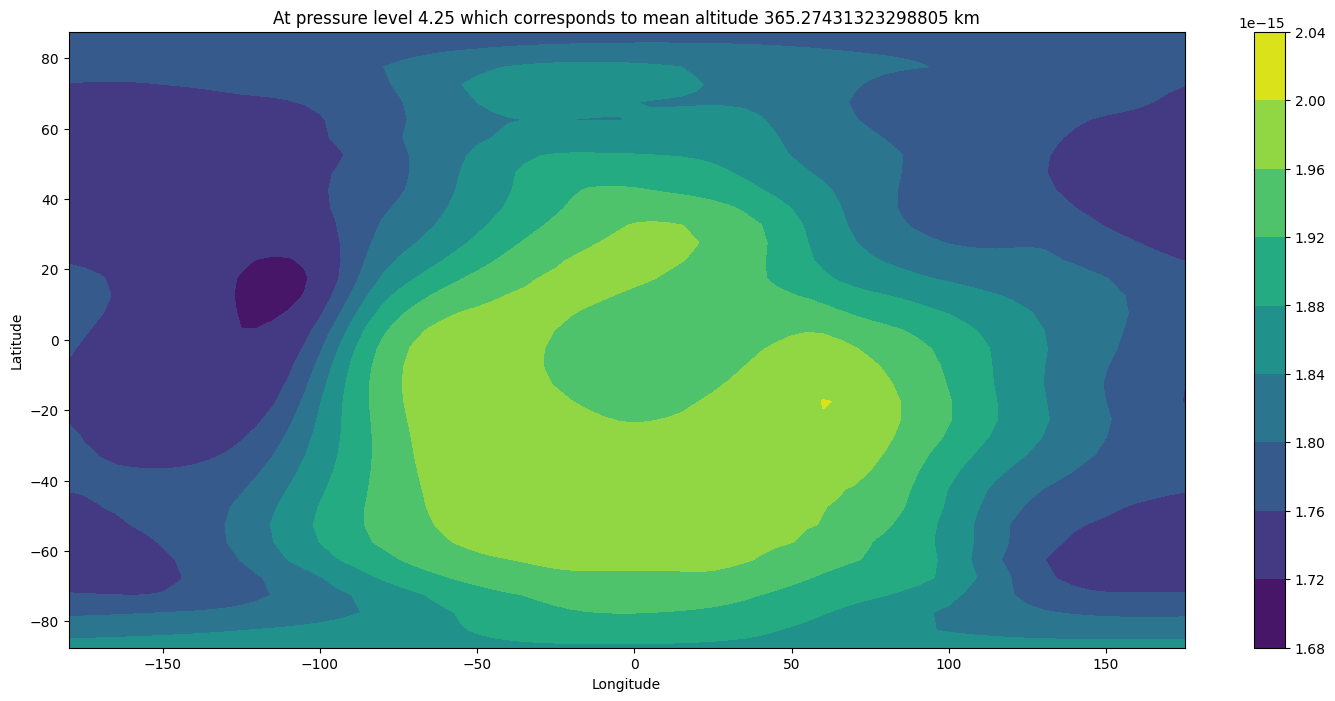

In [39]:
plt.figure(figsize=(18,8))
X,Y = np.meshgrid(tiegcm.lon,tiegcm.lat)
plt.contourf(X,Y, tiegcm.DEN[0,22,:,:], cmap = 'viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'At pressure level {tiegcm.lev.values[22]} which corresponds to mean altitude {np.mean(tiegcm.ZG_lev.values[22,:,:]/10**5)} km')
plt.colorbar()
plt.show()

In [40]:
#tiegcm.lon

In [41]:
levrange = np.linspace(-6.75,7.25,58)
latrange = np.linspace(-87.5,87.5,36)
lonrange = np.linspace(-180,175,72)

den = np.empty((58,36,72))

In [42]:
for idxi, i in enumerate(levrange):
    for idxj, j in enumerate(latrange):
        for idxk, k in enumerate(lonrange):
            den[idxi,idxj,idxk] = interp2((i,j,k))

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(18,8))
X,Y = np.meshgrid(lonrange,latrange)
plt.contourf(X,Y, den[45,:,:], cmap = 'viridis')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'At pressure level {levrange[45]} which corresponds to mean altitude {None} km')
plt.colorbar()
plt.show()

In [43]:
#################################################
## FUNCTION TO INTERPOLATE IN 3D
#################################################

from scipy.interpolate import RegularGridInterpolator

def interpolate3d(date, time, alt, lat, lon):
  '''INPUTS: date = '175' or '176' for 23 or 24 June 2008
             time = 00-23 in string format
             alt, lat, lon = how many altitude, latitude, longitude points.'''

  tiegcm = xr.open_dataset(f'/content/gdrive/MyDrive/msci_satellite_data/tiegcm_dietrich_truth/tiegcm_trueLow.nc.{date}0{time}')
  interp4 = RegularGridInterpolator((tiegcm.lev, tiegcm.lat, tiegcm.lon), tiegcm.DEN.values[0,:,:,:], method='linear')

  levrange = np.linspace(-6.75,7.25,alt)
  latrange = np.linspace(-87.5,87.5,lat)
  lonrange = np.linspace(-180,175,lon)

  density = np.empty((alt,lat,lon))
  for idxi, i in enumerate(levrange):
    for idxj, j in enumerate(latrange):
        for idxk, k in enumerate(lonrange):
            density[idxi,idxj,idxk] = interp4((i,j,k))

  return density

In [ ]:
#######################################################
## CODE TO PREPARE THE DATA FOR 4D INTERPOLATION
#######################################################

import os
folder = ('/content/gdrive/MyDrive/msci_satellite_data/tiegcm_dietrich_truth')
filenames = []
for file in os.listdir(folder):
    filename = os.fsdecode(file)
    filenames.append(filename)
filenames.sort()
filenames = filenames[:-2]
print(filenames)

levrange4 = np.linspace(-6.75,7.25,29)
latrange4 = np.linspace(-87.5,87.5,36)
lonrange4 = np.linspace(-180,175,72)

four_dim_density = np.empty((len(filenames), 29, 36, 72))

for idx, filename in enumerate(filenames):
    ds = xr.open_dataset('/content/gdrive/MyDrive/msci_satellite_data/tiegcm_dietrich_truth/'+f'{filename}')
    for t in np.arange(0,46,1):
        for idxi, i in enumerate(levrange4):
            for idxj, j in enumerate(latrange4):
                for idxk, k in enumerate(lonrange4):
                    four_dim_density[t, idxi, idxj, idxk] = ds.DEN.values[0, idxi, idxj, idxk]

['tiegcm_trueLow.nc.175001', 'tiegcm_trueLow.nc.175002', 'tiegcm_trueLow.nc.175003', 'tiegcm_trueLow.nc.175004', 'tiegcm_trueLow.nc.175005', 'tiegcm_trueLow.nc.175006', 'tiegcm_trueLow.nc.175007', 'tiegcm_trueLow.nc.175008', 'tiegcm_trueLow.nc.175009', 'tiegcm_trueLow.nc.175010', 'tiegcm_trueLow.nc.175011', 'tiegcm_trueLow.nc.175012', 'tiegcm_trueLow.nc.175013', 'tiegcm_trueLow.nc.175014', 'tiegcm_trueLow.nc.175015', 'tiegcm_trueLow.nc.175016', 'tiegcm_trueLow.nc.175017', 'tiegcm_trueLow.nc.175018', 'tiegcm_trueLow.nc.175019', 'tiegcm_trueLow.nc.175020', 'tiegcm_trueLow.nc.175021', 'tiegcm_trueLow.nc.175022', 'tiegcm_trueLow.nc.175023', 'tiegcm_trueLow.nc.176000', 'tiegcm_trueLow.nc.176001', 'tiegcm_trueLow.nc.176002', 'tiegcm_trueLow.nc.176003', 'tiegcm_trueLow.nc.176004', 'tiegcm_trueLow.nc.176005', 'tiegcm_trueLow.nc.176006', 'tiegcm_trueLow.nc.176007', 'tiegcm_trueLow.nc.176008', 'tiegcm_trueLow.nc.176009', 'tiegcm_trueLow.nc.176010', 'tiegcm_trueLow.nc.176011', 'tiegcm_trueLow.nc.

In [ ]:
four_dim_density[:,0,0,0]

array([8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10, 8.78111639e-10, 8.78111639e-10,
       8.78111639e-10, 8.78111639e-10])

In [ ]:
#################################################
## FUNCTION TO INTERPOLATE IN 4D
#################################################

from scipy.interpolate import RegularGridInterpolator

def interpolate4d(denarray, time, alt, lat, lon):
  '''INPUTS:  denarray = four_dim_density # for clarity so that it is explicity called into the function
              time, alt, lat, lon = how many time, altitude, latitude, longitude points.'''

  timrange4 = np.arange(0,46,1)
  levrange4 = np.linspace(-6.75,7.25,29)
  latrange4 = np.linspace(-87.5,87.5,36)
  lonrange4 = np.linspace(-180,175,72)

  interp5 = RegularGridInterpolator((timrange4, levrange4, latrange4, lonrange4), four_dim_density[:,:,:,:], method='linear')

  timrange5 = np.linspace(0,45,time)
  levrange5 = np.linspace(-6.75,7.25,alt)
  latrange5 = np.linspace(-87.5,87.5,lat)
  lonrange5 = np.linspace(-180,175,lon)

  density = np.empty((time,alt,lat,lon))
  for idxt, t in enumerate(timrange5):
    for idxi, i in enumerate(levrange):
      for idxj, j in enumerate(latrange):
          for idxk, k in enumerate(lonrange):
              density[idxt,idxi,idxj,idxk] = interp5((t,i,j,k))

  return density

In [ ]:
##################################################
## RUNNING SOME TESTS - 3D INTERPOLATION
##################################################

print(f'The model density for UT01 on 23/06/08 at pressure level {tiegcm.lev[1]}, latitude {tiegcm.lat[2]}, longitude {tiegcm.lon[3]} is {tiegcm.DEN.values[0,1,2,3]}')
denarray_interpolated = interpolate3d('175', '01', 29, 36, 72)
print(f'The interpolated model density for UT01 on 23/06/08 at pressure level {tiegcm.lev[1]}, latitude {tiegcm.lat[2]}, longitude {tiegcm.lon[3]} is {denarray_interpolated.values[0,1,2,3]}')

The model density for UT01 on 23/06/08 at pressure level <xarray.DataArray 'lev' ()>
array(-6.25)
Coordinates:
    lev      float64 -6.25
    ilev     float64 ...
Attributes:
    short_name:  ln(p0/p), latitude <xarray.DataArray 'lat' ()>
array(-77.5)
Coordinates:
    lat      float64 -77.5
Attributes:
    units:    degrees, longitude <xarray.DataArray 'lon' ()>
array(-165.)
Coordinates:
    lon      float64 -165.0
Attributes:
    units:    degrees is 5.607356801107244e-10


AttributeError: 'numpy.ndarray' object has no attribute 'values'